In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec, phrases
import re
from scipy import interp
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from collections import Counter
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
import nltk
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import multiprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold,train_test_split,GridSearchCV
from beautifultable import BeautifulTable
from sklearn.metrics import confusion_matrix,roc_curve, precision_recall_fscore_support, auc, accuracy_score, f1_score,precision_score,recall_score, make_scorer

In [2]:
def read_file(df_new):
    print("Started extracting data from file",df_new.shape)
    dfnew=pd.DataFrame()
    dfnew.insert(0,'Post',None)
    dfnew.insert(1,'class',None)
    for val in df_new.values:
        appList=[]
        sp=np.array_str(val).split(",")
        if len(sp)==2:
            appList.append(sp[0])
            appList.append(sp[1])
            dfnew.loc[len(dfnew)]=appList
    for i in range(0,dfnew.shape[0]):
        dfnew.values[i][1]=int(dfnew.values[i][1].strip("\'|]|\""))
    print(dfnew['class'].value_counts())
    print("Finished extracting data from file",dfnew.shape)
    return dfnew

In [3]:
def post_tokenizing_dataset1(df):
    print("Started cleaning data in dataframe", df.shape)
    #print(df.head(5))
    wpt = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')
    lancaster_stemmer=LancasterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    token_list=[]
    phrase_list=[]
    token_df=pd.DataFrame()
    token_df.insert(0,'Post',None)
    token_df.insert(1,'class',None)
    for val in df.values:
        append_list=[]
        filter_val=re.sub(r'Q:','',val[0])
        filter_val=re.sub(r'&#039;[a-z]{1}','',filter_val)
        filter_val=re.sub('<[a-z]+>',' ',filter_val).lower()
        filter_val=re.sub(r'[^a-zA-Z\s]', '', filter_val, re.I|re.A)
        filter_val=[token for token in wpt.tokenize(filter_val)]
        filter_val=[word for word in filter_val if word.isalpha()]
        lemma_tokens=[wordnet_lemmatizer.lemmatize(token) for token in filter_val if token not in stop_words and len(token)>=3]
        lancaster_tokens = [lancaster_stemmer.stem(word) for word in lemma_tokens]
        if(lancaster_tokens):
            append_list.append(' '.join(lancaster_tokens))
            append_list.append(val[1])
            token_df.loc[len(token_df)]=append_list
    print("Finished cleaning data in dataframe",token_df.shape)
    #print(token_df.head(5))
    return token_df

In [4]:
def post_tokenizing_dataset3(df):
    print("Started cleaning data in dataframe", df.shape)
    #print(df.head(5))
    wpt = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')
    lancaster_stemmer=LancasterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    token_df=pd.DataFrame()
    token_df.insert(0,'Post',None)
    token_df.insert(1,'class',None)
    
    for val in df.values:
        filter_val=[]
        value=re.sub(r'@\w*','',val[0])
        value=re.sub(r'&.*;','',value)
        value=re.sub(r'http[s?]?:\/\/.*[\r\n]*','',value)
        tokens=[token for token in wpt.tokenize(value)]
        tokens=[word for word in tokens if word.isalpha()]
        lemma_tokens=[wordnet_lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token)>=3]
        lancaster_tokens = [lancaster_stemmer.stem(word) for word in lemma_tokens]
        if len(lancaster_tokens)!=0:
            filter_val.append(' '.join(lancaster_tokens).lower())
            filter_val.append(val[1])
            token_df.loc[len(token_df)]=filter_val
    
    print("Finished cleaning data in dataframe",token_df.shape)
    #print(token_df.head(5))
    return token_df

In [5]:
def post_vector_calculation(token_df,embeddings):    
    texts=[]
    docs_vectors=pd.DataFrame()
    for val in token_df.values:
        texts.append(val[0])
    vec = TfidfVectorizer()
    vec.fit(texts)
    dictionary=dict(zip(vec.get_feature_names(),list(vec.idf_)))
    tfidf_features=vec.get_feature_names()
    row=0
    for sent in texts:
        sent_vec=np.zeros(embeddings.layer1_size)
        weight_sum=0
        for word in sent.split():
            if word in embeddings.wv.vocab and word in tfidf_features:
                vec=embeddings[word]
                tf_idf=dictionary[word]*(sent.count(word)/len(sent))
                sent_vec+=(vec*tf_idf)
                weight_sum+=tf_idf
        if weight_sum !=0:
            sent_vec /= weight_sum
        docs_vectors=docs_vectors.append(pd.Series(sent_vec),ignore_index = True)
    docs_vectors['class']=token_df['class']
    return docs_vectors

In [6]:
def counter_word(text):
    print("Started counting words")
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    print("Finished post vector calculation :")
    return count

In [7]:
def remove_less_occurent_words(token_df,counter):
    print("Started removing less occurent words",token_df.shape)
    token_df_2=pd.DataFrame()
    token_df_2.insert(0,'Post',None)
    token_df_2.insert(1,'class',None)
    less_list=[]
    for key,val in counter.items():
        if(val==1):
            less_list.append(key)
    for val in token_df.values:
        list_2=[]
        split_list=[]
        split_list=val[0].split(' ')
        for word in split_list:
            if word in less_list:
                split_list.remove(word)
        list_2.append(' '.join(split_list))
        list_2.append(val[1])
        token_df_2.loc[len(token_df_2)]=list_2
    print("Finished removing less occurent words",token_df_2.shape)
    return token_df_2

In [8]:
df_data_1=read_file(pd.read_csv("../../post.csv",sep="\t"))
df_data_2=read_file(pd.read_csv("../../new_data.csv",sep=","))
df_data_3=pd.read_csv("../../dataset_4.csv",sep=",")

Started extracting data from file (12642, 1)
0    10794
1     1848
Name: class, dtype: int64
Finished extracting data from file (12642, 2)
Started extracting data from file (8856, 1)
0    6312
1    2505
Name: class, dtype: int64
Finished extracting data from file (8817, 2)


In [9]:
tk=df_data_3[df_data_3['class']==1].iloc[0:7500,]
post_tk=post_tokenizing_dataset3(tk)
post_tk=post_tk.append(df_data_1[df_data_1['class']==0].iloc[0:7500,], ignore_index=True)
print(post_tk['class'].value_counts())

post_tk=sklearn.utils.shuffle(post_tk)
counter_tk = counter_word(post_tk['Post'])
print(len(counter_tk))
token_tk=remove_less_occurent_words(post_tk,counter_tk)
print(tk.shape)

Started cleaning data in dataframe (7500, 2)
Finished cleaning data in dataframe (7084, 2)
0    7500
1    7084
Name: class, dtype: int64
Started counting words
Finished post vector calculation :
28451
Started removing less occurent words (14584, 2)
Finished removing less occurent words (14584, 2)
(7500, 2)


In [10]:
token_list=[]
for val in token_tk.values:
    token_list.append(val[0].split())
    
cores = multiprocessing.cpu_count()

embeddings=Word2Vec(token_list,min_count=10,
                 window=2,
                 size=300,
                 sample=6e-5, 
                 alpha=0.03, 
                 min_alpha=0.0007, 
                 negative=2,
                 workers=cores)
print(len(embeddings.wv.vocab))
tfidf_vector=post_vector_calculation(token_tk,embeddings)
tfidf_vector=tfidf_vector.dropna()

2019


C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  if sys.path[0] == '':
C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(tfidf_vector.drop('class', axis = 1),tfidf_vector['class'],test_size = 0.2,
                                                    stratify=tfidf_vector['class'],random_state = 42)

In [12]:
print(X_train.shape, X_test.shape)

(11667, 300) (2917, 300)


In [13]:
print(y_train.shape,y_test.shape)

(11667,) (2917,)


In [14]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

## Evaluation Metrics

In [15]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
def model_evaluation(X_test, y_test, model):
    _probabilities = model.predict_proba(X_test)[:, 1]
    _predicted_values = model.predict(X_test)
    _accuracy = accuracy_score(y_test, _predicted_values)
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    _auc = auc(_fpr, _tpr)
    if X_test.shape[0]!=1:
        tn, fp, fn, tp = confusion_matrix(y_test, _predicted_values).ravel()
        print("Confusion matrix:  tn={tn},  fp={fp},  fn={fn},  tp={tp}".format(tn=tn,fp=fp,fn=fn,tp=tp))
    else:
        print(confusion_matrix(y_test, _predicted_values).ravel())
    return _accuracy, _f1_score[0], _precision[0], _recall[0],_auc,_tpr_transformed

In [16]:
def param_tuning(model, param_dict, X_train, y_train, X_test, y_test):
    

    grid_object = GridSearchCV(estimator = model,
                           param_grid = param_dict,
                           cv = 2,iid=False, refit=True)

    grid_fit = grid_object.fit(X_train, y_train)

    best_model = grid_fit.best_estimator_
    predictions = (model.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_model.predict(X_test)
    accuracy,f1score,precision,recall,auc,tpr=model_evaluation(X_test,y_test,best_model)
   
    print(model.__class__.__name__)
    print("\nOptimized Model\n------")
    print("Best Parameters: {}".format(grid_fit.best_params_))
    print("Accuracy: {:.4f}".format(accuracy))
    print("F1-score: {:.4f}".format(f1score))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("AUC: {:.4f}".format(auc))
    #tn, fp, fn, tp = confusion_matrix(y_test, best_predictions).ravel()
    #print("Confusion matrix:  tn={tn},  fp={fp},  fn={fn},  tp={tp}".format(tn=tn,fp=fp,fn=fn,tp=tp))
    return grid_object,accuracy,f1score,precision,recall,auc,tpr

## ADA Boost

In [17]:
pipe = Pipeline([('scaler',MinMaxScaler()),('fs',SelectKBest()),
                ('ada', AdaBoostClassifier())])

param_grid = {
    'ada__n_estimators': [1, 2, 4, 6, 8, 32, 100, 200, 500],  
    'ada__random_state': [42],
    'ada__learning_rate' : [1, 0.5, 0.25, 0.05, 0.01],
    'fs__k':[200],
    'fs__score_func':[chi2]
}
model_ada,ADA_accuracy,ADA_f1_score,ADA_precision,ADA_recall,ADA_auc,ADA_tpr= param_tuning(pipe,param_grid,X_train,y_train,X_test,y_test)

Confusion matrix:  tn=1383,  fp=117,  fn=111,  tp=1306
Pipeline

Optimized Model
------
Best Parameters: {'ada__learning_rate': 1, 'ada__n_estimators': 500, 'ada__random_state': 42, 'fs__k': 200, 'fs__score_func': <function chi2 at 0x00000228AB1597B8>}
Accuracy: 0.9218
F1-score: 0.9197
Precision: 0.9178
Recall: 0.9217
AUC: 0.9745


C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


## SVM

In [18]:
param_grid = {
    'svc__C': [0.3,0.6,1],  
    'svc__gamma': [0.001,0.009,0.1,1], 
    'svc__kernel': ['linear'],
    'fs__k':[200],
    'fs__score_func':[chi2]
}


pipe = Pipeline([('scaler',MinMaxScaler()),('fs',SelectKBest()),('svc', SVC(probability=True))])

model_svc,SVC_accuracy,SVC_f1_score,SVC_precision,SVC_recall,SVC_auc,SVC_tpr = param_tuning(pipe,param_grid,X_train,y_train,X_test,y_test)

C:\Users\aml_alx\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Confusion matrix:  tn=1382,  fp=118,  fn=58,  tp=1359
Pipeline

Optimized Model
------
Best Parameters: {'fs__k': 200, 'fs__score_func': <function chi2 at 0x00000228AB1597B8>, 'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}
Accuracy: 0.9397
F1-score: 0.9392
Precision: 0.9201
Recall: 0.9591
AUC: 0.9748


C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


## Random Forest Classifier

In [19]:
param_grid = {
    'rfc__n_estimators': [500, 600],
    'rfc__min_samples_leaf': [1],
    'rfc__min_samples_split': [10],
    'rfc__criterion':['entropy'],
    'rfc__max_depth':[10],
    'fs__k':[200],
    'fs__score_func':[chi2]
}


pipe = Pipeline([('scaler',MinMaxScaler()),('fs',SelectKBest()),('rfc', RandomForestClassifier())])

model_rfc,RFC_accuracy,RFC_f1_score,RFC_precision,RFC_recall,RFC_auc,RFC_tpr  = param_tuning(pipe,param_grid,X_train,y_train,X_test,y_test)

C:\Users\aml_alx\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion matrix:  tn=1337,  fp=163,  fn=104,  tp=1313
Pipeline

Optimized Model
------
Best Parameters: {'fs__k': 200, 'fs__score_func': <function chi2 at 0x00000228AB1597B8>, 'rfc__criterion': 'entropy', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 500}
Accuracy: 0.9085
F1-score: 0.9077
Precision: 0.8896
Recall: 0.9266
AUC: 0.9671


C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


In [20]:
h0=["Algorithm"]
h1=["ADA BOOST",ADA_accuracy,ADA_f1_score,ADA_precision,ADA_recall]
h2=["SVM",SVC_accuracy,SVC_f1_score,SVC_precision,SVC_recall]
h3=["Random Forest",RFC_accuracy,RFC_f1_score,RFC_precision,RFC_recall]


h0.append("Accuracy")
h0.append("F1 Measure")
h0.append("Precision")
h0.append("Recall")

table = BeautifulTable()
table.column_headers = h0
table.append_row(h1)
table.append_row(h2)
table.append_row(h3)
print(table)

+---------------+----------+------------+-----------+--------+
|   Algorithm   | Accuracy | F1 Measure | Precision | Recall |
+---------------+----------+------------+-----------+--------+
|   ADA BOOST   |  0.922   |    0.92    |   0.918   | 0.922  |
+---------------+----------+------------+-----------+--------+
|      SVM      |   0.94   |   0.939    |   0.92    | 0.959  |
+---------------+----------+------------+-----------+--------+
| Random Forest |  0.908   |   0.908    |   0.89    | 0.927  |
+---------------+----------+------------+-----------+--------+


C:\Users\aml_alx\Anaconda3\lib\site-packages\beautifultable\utils.py:113: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
C:\Users\aml_alx\Anaconda3\lib\site-packages\beautifultable\utils.py:113: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


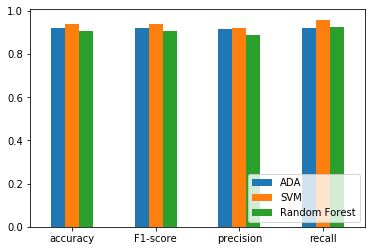

In [21]:
ADA_metrics=np.array([ADA_accuracy,ADA_f1_score,ADA_precision,ADA_recall])
SVM_metrics = np.array([SVC_accuracy,SVC_f1_score,SVC_precision,SVC_recall])
RF_metrics = np.array([RFC_accuracy,RFC_f1_score,RFC_precision,RFC_recall])
index = ['accuracy', 'F1-score', 'precision', 'recall']
df_metrics = pd.DataFrame({'ADA': ADA_metrics, 'SVM':SVM_metrics,'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

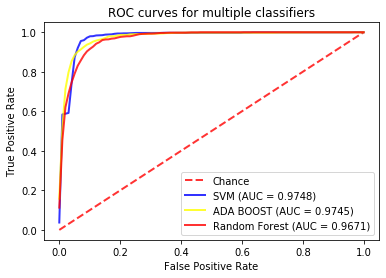

In [22]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVC_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.4f)' % (SVC_auc), alpha=0.8)
plt.plot(mean_fpr, ADA_tpr[0,:], lw=2, color='yellow', label='ADA BOOST (AUC = %0.4f)' % (ADA_auc), alpha=0.8)
plt.plot(mean_fpr, RFC_tpr[0,:], lw=2, color='red', label='Random Forest (AUC = %0.4f)' % (RFC_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

## Testing

In [23]:
test_data=pd.DataFrame()
t1=df_data_2[df_data_2['class']==0].iloc[0:1000,]
t1=post_tokenizing_dataset1(t1)
t2=df_data_3[df_data_3['class']==1].iloc[8000:9000,]
t2=post_tokenizing_dataset3(t2)
test_data=test_data.append(t1 , ignore_index = True)
test_data=test_data.append(t2 , ignore_index = True)
test_data=sklearn.utils.shuffle(test_data)
print(test_data['class'].value_counts())
counter_test_data= counter_word(test_data['Post'])
print(len(counter_test_data))
test_data=remove_less_occurent_words(test_data,counter_test_data)

Started cleaning data in dataframe (1000, 2)
Finished cleaning data in dataframe (998, 2)
Started cleaning data in dataframe (1000, 2)
Finished cleaning data in dataframe (999, 2)
1    999
0    998
Name: class, dtype: int64
Started counting words
Finished post vector calculation :
3403
Started removing less occurent words (1997, 2)
Finished removing less occurent words (1997, 2)


In [24]:
token_list_test=[]
for val in test_data.values:
    token_list_test.append(val[0].split())

embeddings_test=Word2Vec(token_list_test,min_count=1,
                 window=2,
                 size=300,
                 sample=6e-5, 
                 alpha=0.03, 
                 min_alpha=0.0007, 
                 negative=2,
                 workers=cores)
print(len(embeddings.wv.vocab))
test_data=post_vector_calculation(test_data,embeddings_test)

2019


C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  if sys.path[0] == '':
C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [25]:
def measure_model(token_df_test,model):
    X=token_df_test.drop('class',axis=1)
    y=token_df_test['class']
    y=y.astype('int')
    accuracy, f1, precision, recall,_,_=model_evaluation(X,y,model)
    return accuracy, precision, recall, f1

## Ada Boost

In [26]:
ADA_accuracy_test,ADA_f1_score_test,ADA_precision_test,ADA_recall_test=measure_model(test_data,model_ada)
print("accuracy:{a},   precision:{p},   recall:{r},   f1:{f}".format(a=ADA_accuracy_test,p=ADA_precision_test,r=ADA_recall_test,f=ADA_f1_score_test))

Confusion matrix:  tn=187,  fp=811,  fn=214,  tp=785
accuracy:0.4867300951427141,   precision:0.7857857857857858,   recall:0.605009633911368,   f1:0.4918546365914787


C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


## Random Forest

In [27]:
RFC_accuracy_test,RFC_f1_score_test,RFC_precision_test,RFC_recall_test=measure_model(test_data,model_rfc)
print("accuracy:{a},   precision:{p},   recall:{r},   f1:{f}".format(a=RFC_accuracy_test,p=RFC_precision_test,r=RFC_recall_test,f=RFC_f1_score_test))

Confusion matrix:  tn=995,  fp=3,  fn=997,  tp=2
accuracy:0.4992488733099649,   precision:0.002002002002002002,   recall:0.00398406374501992,   f1:0.4


C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


## SVM

In [28]:
SVC_accuracy_test, SVC_f1_score_test, SVC_precision_test, SVC_recall_test=measure_model(test_data,model_svc)
print("accuracy:{a},   precision:{p},   recall:{r},   f1:{f}".format(a=SVC_accuracy_test,p=SVC_precision_test,r=SVC_recall_test,f=SVC_f1_score_test))

Confusion matrix:  tn=4,  fp=994,  fn=1,  tp=998
accuracy:0.5017526289434151,   precision:0.998998998998999,   recall:0.6673353393513877,   f1:0.501004016064257


C:\Users\aml_alx\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


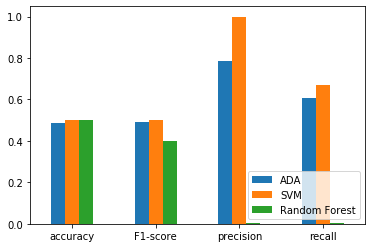

In [29]:
ADA_metrics_test=np.array([ADA_accuracy_test,ADA_f1_score_test,ADA_precision_test,ADA_recall_test])
SVM_metrics_test = np.array([SVC_accuracy_test,SVC_f1_score_test,SVC_precision_test,SVC_recall_test])
RF_metrics_test = np.array([RFC_accuracy_test,RFC_f1_score_test,RFC_precision_test,RFC_recall_test])
index = ['accuracy', 'F1-score','precision', 'recall']
df_metrics = pd.DataFrame({'ADA': ADA_metrics_test,'SVM':SVM_metrics_test,'Random Forest': RF_metrics_test}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()